# Зависимость оценки от тематики статьи

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_json('data/clf_train_20170726.json')

In [4]:
data.head()

,class,class_name,context,dialogId,evaluation,thread,users
0,9,rec.sport.baseball,"At the age of 10, West moved with his mother t...",524099220,"[{u'userId': u'Bob', u'quality': 4}, {u'userId...","[{u'text': u'how are you?', u'userId': u'Bob'}...","[{u'userType': u'Human', u'id': u'Bob'}, {u'us..."
1,13,sci.med,"Once a neuron is in place, it extends dendrite...",1721190162,"[{u'userId': u'Bob', u'quality': 1}, {u'userId...","[{u'text': u'hi', u'userId': u'Alice'}, {u'tex...","[{u'userType': u'Human', u'id': u'Alice'}, {u'..."
10,6,misc.forsale,"A freight elevator, or goods lift, is an eleva...",470978068,"[{u'userId': u'Alice', u'quality': 1}, {u'user...",[{u'text': u'which one is larger: Freight or p...,"[{u'userType': u'Human', u'id': u'Bob'}, {u'us..."
100,13,sci.med,Dunn and Dunn focused on identifying relevant ...,2031672262,"[{u'userId': u'Alice', u'quality': 0}, {u'user...",[{u'text': u'I don't understand what's Intelli...,"[{u'userType': u'Human', u'id': u'Alice'}, {u'..."
101,19,talk.religion.misc,"In Germany, practical reference works intended...",1401445483,"[{u'userId': u'Alice', u'quality': 1}, {u'user...","[{u'text': u'hi', u'userId': u'Bob', u'time': ...","[{u'userType': u'Human', u'id': u'Bob'}, {u'us..."


In [5]:
def get_score(diag, user):
    score = list(filter(lambda x: x["userId"] == user, diag["evaluation"]))[0]["quality"]
    score = 1 if score >= 2 else 0
    return score

def get_type(diag, user):
    u = list(filter(lambda x: x["id"] == user, diag["users"]))[0]['userType']
    return 1 if u == "Bot" else 0

def get_human_evaluation(diag):
    a_type = get_type(diag, 'Alice')
    b_type = get_type(diag, 'Bob')
    if (a_type and b_type) or not (a_type or b_type):
        return None
    if a_type:
        return get_score(diag, 'Alice')
    return get_score(diag, 'Bob')

In [6]:
def get_class_stat(data):
    data['human_score'] = data.apply(get_human_evaluation, axis=1)

    bad_df = data[data['human_score'] == 0].groupby('class_name').agg({'dialogId': 'count'}).reset_index()
    good_df = data[data['human_score'] == 1].groupby('class_name').agg({'dialogId': 'count'}).reset_index()
    all_df = data.groupby('class_name').agg({'dialogId': 'count'}).reset_index()
    
    good_count = len(data[data['human_score'] == 1].values)

    bad_df = pd.merge(bad_df, all_df, how='inner', on='class_name')
    bad_df['ratio'] = np.divide(bad_df['dialogId_x'].values * 100.0, bad_df['dialogId_y'].values)

    good_df = pd.merge(good_df, all_df, how='inner', on='class_name')
    good_df['good_ratio'] = np.divide(good_df['dialogId_x'].values * 100.0, good_count)
    good_df['class_ratio'] = np.divide(good_df['dialogId_x'].values * 100.0, good_df['dialogId_y'].values)
    
    return bad_df, good_df

In [20]:
_, good_df_20170726 = get_class_stat(data)

train_20170725 = pd.read_json('data/clf_train_20170725.json')
_, good_df_20170725 = get_class_stat(train_20170725)

train_20170724 = pd.read_json('data/clf_train_20170724.json')
_, good_df_20170724 = get_class_stat(train_20170724)

In [26]:
data_by_day = pd.merge(good_df_20170724, good_df_20170725, how='inner', on='class_name')

data_by_day = pd.merge(data_by_day, good_df_20170726, how='inner', on='class_name')
data_by_day = data_by_day.drop(['dialogId_x_x', 'dialogId_y_x', 'dialogId_x_y', 'dialogId_y_y',
                                'dialogId_x', 'dialogId_y'], axis=1)

In [27]:
data_by_day

,class_name,good_ratio_x,class_ratio_x,good_ratio_y,class_ratio_y,good_ratio,class_ratio
0,comp.windows.x,1.315789,10.000000,2.739726,40.000000,1.886792,33.333333
1,misc.forsale,6.578947,25.000000,1.369863,10.000000,1.886792,25.000000
2,rec.sport.baseball,3.947368,21.428571,4.109589,27.272727,3.773585,44.444444
3,rec.sport.hockey,3.947368,17.647059,2.739726,22.222222,6.603774,58.333333
4,sci.electronics,5.263158,14.814815,8.219178,33.333333,8.490566,39.130435
5,sci.med,7.894737,15.789474,13.698630,28.571429,13.207547,36.842105
6,sci.space,13.157895,29.411765,5.479452,33.333333,12.264151,59.090909
7,soc.religion.christian,9.210526,18.421053,10.958904,32.000000,12.264151,38.235294
8,talk.politics.mideast,18.421053,23.728814,19.178082,38.888889,16.037736,34.693878
9,talk.politics.misc,11.842105,20.454545,13.698630,27.777778,15.094340,43.243243


### Доля хороших диалогов от всех диалогов по этой тематике

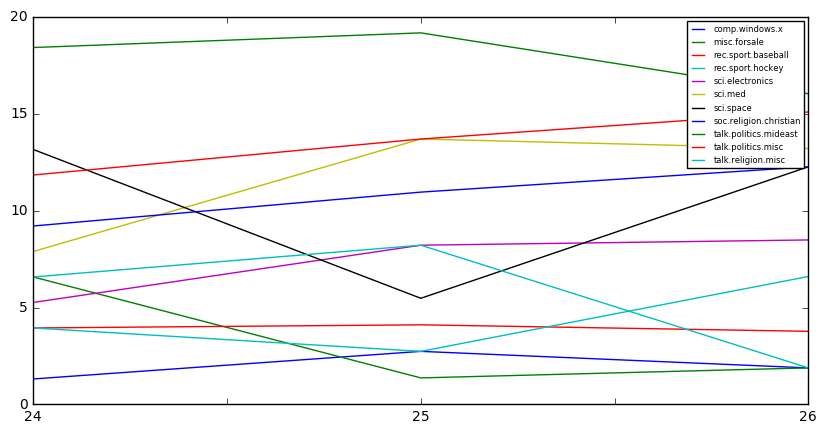

In [51]:
plot_df  = data_by_day.drop(['class_ratio_x', 'class_ratio_y', 'class_ratio'], axis=1)
plot_df.columns = ['class_name', '24', '25', '26']
plot_df = plot_df.set_index('class_name').T
plot_df.class_name = ['24', '25', '26']
plot_df.plot(figsize=(10, 5), legend=True).legend(ncol=1,markerscale=0.5,fontsize=6)

### Доля хороших диалогов, которая досталась это тематике от всех хороших диалогов

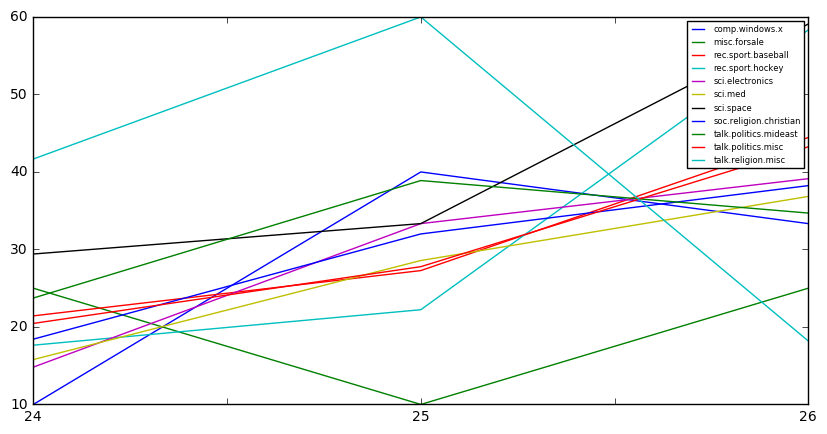

In [53]:
plot_df  = data_by_day.drop(['good_ratio_x', 'good_ratio_y', 'good_ratio'], axis=1)
plot_df.columns = ['class_name', '24', '25', '26']
plot_df = plot_df.set_index('class_name').T
plot_df.class_name = ['24', '25', '26']
plot_df.plot(figsize=(10, 5), legend=True).legend(ncol=1,markerscale=0.5,fontsize=6)